In [15]:
from ode_composer.statespace_model import StateSpaceModel
from scipy.integrate import solve_ivp
from ode_composer.dictionary_builder import DictionaryBuilder
from ode_composer.sbl import SBL
from ode_composer.measurements_generator import MeasurementsGenerator
import matplotlib.pyplot as plt
import numpy as np
import time
from ode_composer.signal_preprocessor import (
    GPSignalPreprocessor,
    RHSEvalSignalPreprocessor,
    SplineSignalPreprocessor,
)

In [16]:
# define Lotka-Volerra model
states = {"x1": "alpha*x1-beta*x1*x2", "x2": "delta*x1*x2-gamma*x2"}
parameters = {"alpha": 2 / 3, "beta": 4 / 3, "delta": 2, "gamma": 1}
ss = StateSpaceModel.from_string(states=states, parameters=parameters)
print("Original Model:")
print(ss)


Original Model:
dx1/dt = +1.00e+00*-1.33333333333333*x1*x2 + 0.666666666666667*x1
dx2/dt = +1.00e+00*2*x1*x2 - x2



In [17]:
t_span = [0, 30]
x0 = {"x1": 1.2, "x2": 1.0}
data_points = 300
SNR = 8
# simulate model
gm = MeasurementsGenerator(
    ss=ss, time_span=t_span, initial_values=x0, data_points=data_points
)
t, y = gm.get_measurements(SNR_db=SNR)

In [18]:
start_time = time.time()
gproc = GPSignalPreprocessor(t=t, y=y[0, :], selected_kernel="RBF")
y_samples_1, t_gp = gproc.interpolate(return_extended_time=True, noisy_obs=True)
gproc.calculate_time_derivative()
dydt_1 = gproc.dydt
dydt_1_std = gproc.A_std

gproc_2 = GPSignalPreprocessor(t=t, y=y[1, :], selected_kernel="RatQuad")
y_samples_2, _ = gproc_2.interpolate(noisy_obs=True)
gproc_2.calculate_time_derivative()
dydt_2 = gproc_2.dydt
dydt_2_std = gproc_2.A_std

print("Time for the estimation of the derivatives through GPs:")
print(time.time() - start_time)

Time for the estimation of the derivatives through GPs:
0.33829617500305176


In [19]:
spline_1 = SplineSignalPreprocessor(t, y[0,:])
x_spline = spline_1.interpolate(t)
dx_spline = spline_1.calculate_time_derivative(t)

spline_2 = SplineSignalPreprocessor(t, y[1,:])
y_spline = spline_2.interpolate(t)
dy_spline = spline_2.calculate_time_derivative(t)


rhs_preprop = RHSEvalSignalPreprocessor(
    t=t, y=y, rhs_function=ss.get_rhs, states=states
)

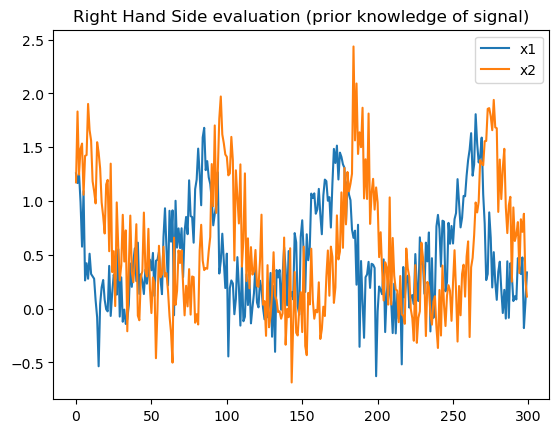

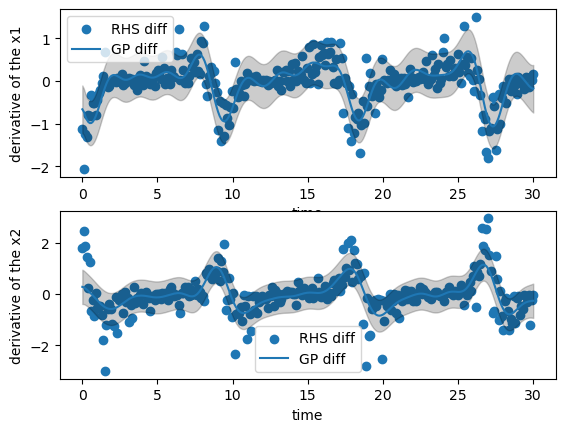

In [20]:
plt.plot(y[0,:])
plt.plot(y[1,:])
plt.title("Right Hand Side evaluation (prior knowledge of signal)")
plt.legend(['x1', 'x2'])
plt.show()
rhs_preprop.calculate_time_derivative()
dydt_rhs = rhs_preprop.dydt
dx1 = dydt_rhs[0, :]
dx2 = dydt_rhs[1, :]

plt.subplot(211)
plt.scatter(t, dx1, label="RHS diff")
plt.plot(t_gp, dydt_1, label="GP diff")
plt.fill_between(t_gp, dydt_1 - 2*dydt_1_std, dydt_1 + 2*dydt_1_std, alpha=0.2, color='k')
plt.ylabel("derivative of the x1")
plt.xlabel("time")
plt.legend(loc="best")
plt.subplot(212)
plt.scatter(t, dx2, label="RHS diff")
plt.plot(t_gp, dydt_2, label="GP diff")
plt.fill_between(t_gp, dydt_2 - 2*dydt_2_std, dydt_2 + 2*dydt_2_std, alpha=0.2, color='k')
plt.ylabel("derivative of the x2")
plt.xlabel("time")
plt.legend(loc="best")
plt.show()


In [21]:
# step 1 define a dictionary
d_f = ["x1", "x1*x2", "x2", "x1/x2", "x1**2/x2", "x2**2/x1", "1"]
dict_builder = DictionaryBuilder(dict_fcns=d_f)
dict_functions = dict_builder.dict_fcns
# associate variables with data
data = {"x1": y_samples_1.T, "x2": y_samples_2.T}


A = dict_builder.evaluate_dict(input_data=data)


start_time = time.time()

# step 2 define an SBL problem
# with the Lin reg model and solve it
lambda_param_1 = np.sqrt(np.linalg.norm(dydt_1_std)) + 0.1
lambda_param_1 = 0.7
print(lambda_param_1)
sbl_x1 = SBL(
    dict_mtx=A,
    data_vec=dydt_1,
    lambda_param=lambda_param_1,
    state_name="x1",
    dict_fcns=dict_functions,
)
sbl_x1.compute_model_structure()

lambda_param_2 = np.sqrt(np.linalg.norm(dydt_2_std)) + 0.1
lambda_param_2 = 0.5
print(lambda_param_2)
sbl_x2 = SBL(
    dict_mtx=A,
    data_vec=dydt_2,
    lambda_param=lambda_param_2,
    state_name="x2",
    dict_fcns=dict_functions,
)
sbl_x2.compute_model_structure()

print("Time for the structure estimation:")
print(time.time()-start_time)

# step 4 reporting
# #build the ODE
zero_th = 1e-5

ode_model = StateSpaceModel.from_sbl(
    {
        "x1": sbl_x1.get_results(zero_th=zero_th),
        "x2": sbl_x2.get_results(zero_th=zero_th),
    },
    parameters=None,
)
print("Estimated ODE model:")
print(ode_model)

0.7
0.5
Time for the structure estimation:
0.2818491458892822
Estimated ODE model:
dx1/dt = +5.96e-01*x1-1.15e+00*x1*x2
dx2/dt = +1.37e+00*x1*x2-7.11e-01*x2



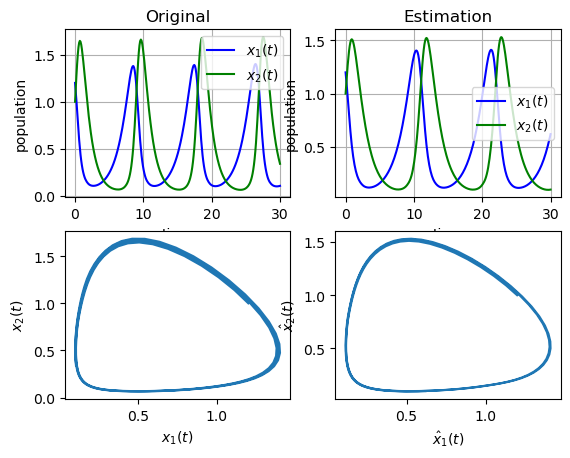

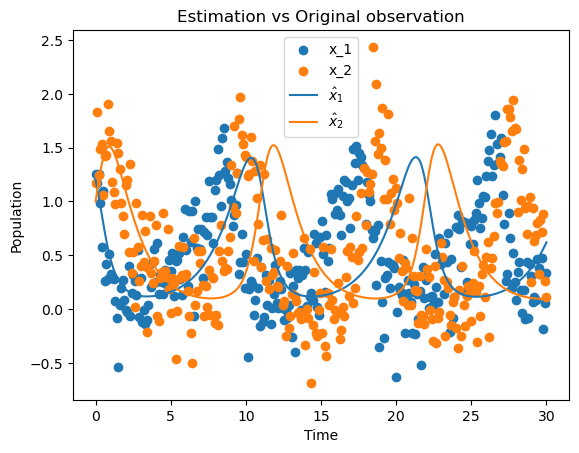

In [22]:

states = ["x1", "x2"]
y0 = [1.2, 1]
sol_ode = solve_ivp(fun=ode_model.get_rhs, t_span=t_span, t_eval=t_gp, y0=y0, args=(states,))
# report
plt.subplot(221)
t_orig, y_orig = gm.get_measurements()
plt.plot(t_orig, y_orig[0, :], "b", label=r"$x_1(t)$")
plt.plot(t_orig, y_orig[1, :], "g", label=r"$x_2(t)$")
plt.legend(loc="best")
plt.xlabel("time")
plt.ylabel("population")
plt.title("Original")
plt.grid()
plt.subplot(222)
plt.plot(sol_ode.t, sol_ode.y[0, :], "b", label=r"$x_1(t)$")
plt.plot(sol_ode.t, sol_ode.y[1, :], "g", label=r"$x_2(t)$")
plt.legend(loc="best")
plt.xlabel("time")
plt.ylabel("population")
plt.title("Estimation")
plt.grid()
plt.subplot(223)
plt.plot(y_orig[0, :], y_orig[1, :])
plt.xlabel(r"$x_1(t)$")
plt.ylabel(r"$x_2(t)$")
plt.subplot(224)
plt.plot(sol_ode.y[0, :], sol_ode.y[1, :])
plt.xlabel(r"$\hat{x}_1(t)$")
plt.ylabel(r"$\hat{x}_2(t)$")
plt.show()

plt.figure()
plt.scatter(t, y[0,:], label=r"x_1")
plt.scatter(t, y[1,:], label=r"x_2")
plt.plot(sol_ode.t, sol_ode.y[0,:], '-', label=r"$\hat{x}_{1}$")
plt.plot(sol_ode.t, sol_ode.y[1,:], '-', label=r"$\hat{x}_{2}$")
plt.legend()
plt.title("Estimation vs Original observation")
plt.xlabel('Time')
plt.ylabel('Population')
plt.show()